In [2]:
import sys
sys.path.insert(0,"/home/nrupatunga/NThere/Caffe-WS/caffe/python")
import caffe

#Load the original network and extract the fully connected layers' parameters.
net = caffe.Net('../models/bvlc_reference_caffenet/deploy.prototxt', 
                '../models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel', caffe.TEST)
print '------------------------------------------------------------------------'
print '-------------------------Network Architecture---------------------------'
print '------------------------------------------------------------------------'
for layername, layerparam in net.params.items():
    print '  Layer Name : {0:>7}, Weight Dims :{1:12} '.format(layername, layerparam[0].data.shape)
print '------------------------------------------------------------------------'

------------------------------------------------------------------------
-------------------------Network Architecture---------------------------
------------------------------------------------------------------------
  Layer Name :   conv1, Weight Dims :(96, 3, 11, 11) 
  Layer Name :   conv2, Weight Dims :(256, 48, 5, 5) 
  Layer Name :   conv3, Weight Dims :(384, 256, 3, 3) 
  Layer Name :   conv4, Weight Dims :(384, 192, 3, 3) 
  Layer Name :   conv5, Weight Dims :(256, 192, 3, 3) 
  Layer Name :     fc6, Weight Dims :(4096, 9216) 
  Layer Name :     fc7, Weight Dims :(4096, 4096) 
  Layer Name :     fc8, Weight Dims :(1000, 4096) 
------------------------------------------------------------------------


In [5]:
print net.blobs['pool5'].data[0].shape

(256, 6, 6)


In [7]:
# Load the fully convolutional network to transplant the parameters.
net_full_conv = caffe.Net('net_surgery/bvlc_caffenet_full_conv.prototxt', 
                          '../models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel',
                          caffe.TEST)

params_full_conv = ['fc6-conv', 'fc7-conv', 'fc8-conv']
# conv_params = {name: (weights, biases)}
conv_params = {pr: (net_full_conv.params[pr][0].data, net_full_conv.params[pr][1].data) for pr in params_full_conv}

for conv in params_full_conv:
    print '{} weights are {} dimensional'.format(conv, conv_params[conv][0].shape)

fc6-conv weights are (4096, 256, 6, 6) dimensional
fc7-conv weights are (4096, 4096, 1, 1) dimensional
fc8-conv weights are (1000, 4096, 1, 1) dimensional


[[282 282 281 281 281 281 277 282]
 [281 283 283 281 281 281 281 282]
 [283 283 283 283 283 283 287 282]
 [283 283 283 281 283 283 283 259]
 [283 283 283 283 283 283 283 259]
 [283 283 283 283 283 283 259 259]
 [283 283 283 283 259 259 259 277]
 [335 335 283 259 263 263 263 277]]


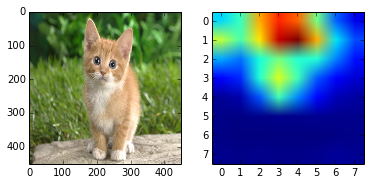

In [14]:
params = ['fc6', 'fc7', 'fc8']
fc_params = {pr: (net.params[pr][0].data, net.params[pr][1].data) for pr in params}
for pr, pr_conv in zip(params, params_full_conv):
    conv_params[pr_conv][0].flat = fc_params[pr][0].flat  # flat unrolls the arrays
    conv_params[pr_conv][1][...] = fc_params[pr][1]
net_full_conv.save('net_surgery/bvlc_caffenet_full_conv.caffemodel')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# load input and configure preprocessing
im = caffe.io.load_image('images/cat.jpg')
transformer = caffe.io.Transformer({'data': net_full_conv.blobs['data'].data.shape})
transformer.set_mean('data', np.load('../python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1))
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)
# make classification map by forward and print prediction indices at each location
out = net_full_conv.forward_all(data=np.asarray([transformer.preprocess('data', im)]))
print out['prob'][0].argmax(axis=0)
# show net input and confidence map (probability of the top prediction at each location)
plt.subplot(1, 2, 1)
plt.imshow(transformer.deprocess('data', net_full_conv.blobs['data'].data[0]))
plt.subplot(1, 2, 2)
plt.imshow(out['prob'][0,281])